# Coherence-Enhancing Diffusion with Optimized Rotation Invariance
## Using the Diffusion Tensor instead of the Structure Tensor
**DOI**:  [Weickert 2022](https://doi.org/10.1006/jvci.2001.0495)

In [1]:
import numpy as np
from scipy.signal import convolve2d

from pyfusion import plotting, loading, gaussian

In [2]:
# All the constants

# Data
DIRNAME = "../../data/example_mri"
SCLICE = 70

# Preprocessing
KERNEL_SIZE = 3
NOISE_SCALE = 0.2  # sigma
INTEGRATION_SCALE = 10  # rho
ALPHA = 0.001
ATOL = 1e-1

# Algorithm
ITERATIONS = 1000
STEP_SIZE = 1

In [3]:
# function for later use
def lambda_func(mu_1, mu_2):  # type: ignore
    """
    Compute the second eigenvalue based on the first eigenvalue and the second mean, if mu_1 and mu_2 are not close.
    """
    return ALPHA + (1 - ALPHA) * np.exp(-1 / (mu_1 - mu_2) ** 2)  # type: ignore

In [4]:
# Load the data
FSL = loading.load_fsl(DIRNAME, SCLICE)

# Add noise
IMG_noisy = FSL.IMAGE + FSL.IMAGE.std() * NOISE_SCALE * np.random.randn(*FSL.IMAGE.shape)

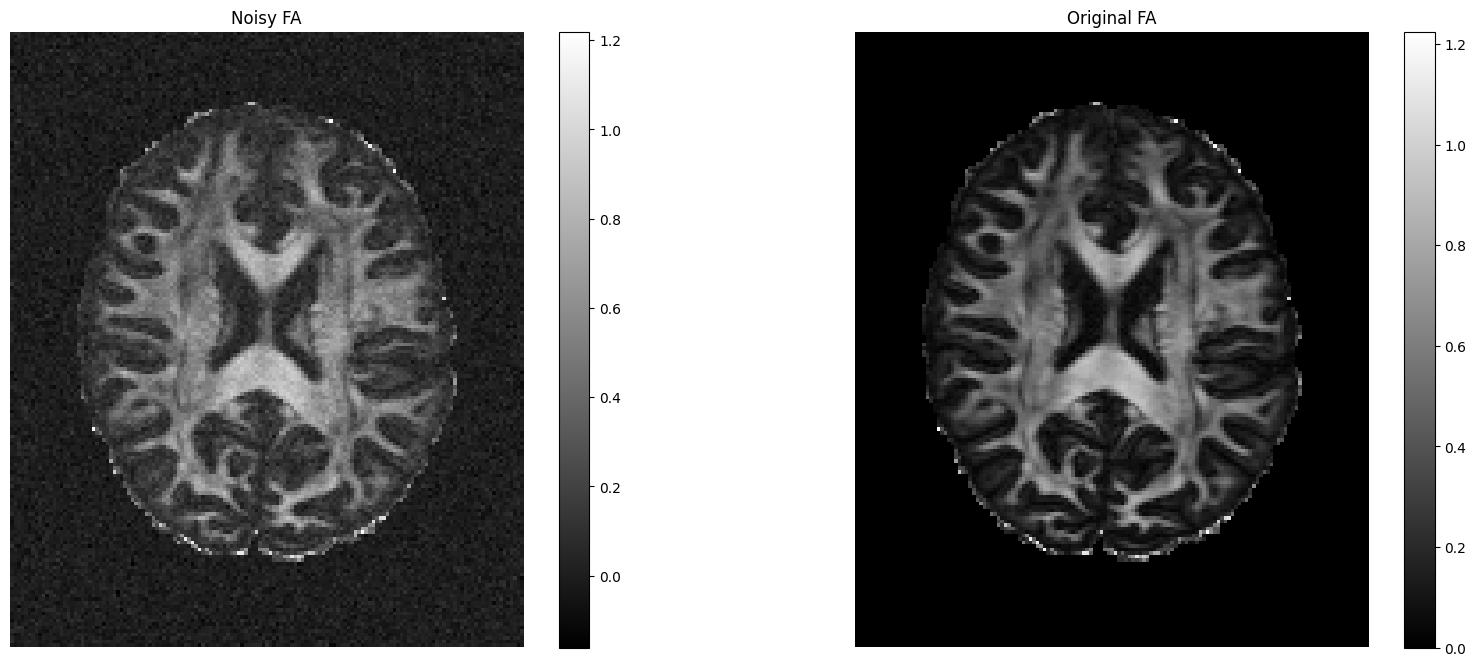

In [5]:
plotting.plot_side_by_side(IMG_noisy, FSL.IMAGE, title_a="Noisy FA", title_b="Original FA")  # type: ignore

Here we want to map the given DTI Tensors to CED Tensors. To achieve this, first we have to project everything to the second dimension.

For that we compute the 3D DTI Tensor from the Eigenvaluedecomposition, and cut out the third coordinate.

In [6]:
V = np.stack([FSL.V1, FSL.V2, FSL.V3], axis=-1)  # type: ignore

Lambda = np.stack([FSL.L1, FSL.L2, FSL.L3], axis=-1)  # type: ignore

V_scaled = V * Lambda[..., np.newaxis, :]  # type: ignore

tensor_field = np.matmul(V_scaled, np.swapaxes(V, -1, -2))  # type: ignore
tensor_field = tensor_field[..., :2, :2]  # type: ignore

For the creation of CED tensor, we have to calculate the EV decomposition of the resulting 2D Tensors. (We assume the result are somewhat orthonormal)

In [7]:
eigval, eigvec = np.linalg.eig(tensor_field)  # type: ignore

idx = np.argsort(eigval, axis=-1)[..., ::-1]  # (n,m,2)

n, m, _, _ = tensor_field.shape
i, j = np.meshgrid(np.arange(n), np.arange(m), indexing="ij")  # type: ignore

eigval = np.take_along_axis(eigval, idx, axis=-1)
eigvec = np.take_along_axis(
    eigvec,
    idx[..., None, :],  # (n,m,1,2) to broadcast correctly
    axis=-1,
)

In [8]:
# for numerical stability
eigval[..., 0] = 1000 * eigval[..., 0]
eigval[..., 1] = 1000 * eigval[..., 1]

Now we are calculating the the angle of the first eigenvector
$$
\begin{bmatrix}
\cos \alpha \\
\sin \alpha
\end{bmatrix}
= v_1
$$

Now as we have the eigen decomposition, we apply CED, by setting new eigenvalues ($\mu_{1, 2}$ being the above calculated eigenvalues).
$$
\lambda_2 = \alpha^\prime, \lambda_1 =
\begin{cases}
\alpha^\prime & \text{, if } \mu_1 = \mu_2 \\
\alpha^\prime + (1 - \alpha^\prime) \cdot \exp (\frac{-C}{(\mu_1 - \mu_2)^{2m}}) & \text{, else}
\end{cases}
$$

As suggested by Weickert we use $C = 1 = m, \alpha^\prime = 0.001$

**Note**: $\lambda_1$ is switched with $\lambda_2$ as CED diffuses in the direction of the second Eigenvector.

In [9]:
alpha_1 = np.arctan2(eigvec[..., 1, 0], eigvec[..., 0, 0])  # type: ignore

lambda_2 = ALPHA
lambda_1 = np.zeros_like(eigval[..., 0])  # type: ignore
mask = np.isclose(eigval[..., 0], eigval[..., 1], atol=ATOL)  # type: ignore
lambda_1[mask] = ALPHA
lambda_1[~mask] = lambda_func(eigval[..., 0][~mask], eigval[..., 1][~mask])  # type: ignore

Then according to weickert the entries of the resulting CED-Diffusion Tensor euquals to
$$
D =
\begin{bmatrix}
a & b \\
b & c
\end{bmatrix}
=
\begin{bmatrix}
\lambda_1 \cos^2 \alpha + \lambda_2 \sin^2 \alpha & (\lambda_1 - \lambda_2) \sin \alpha \cos \alpha \\
(\lambda_1 - \lambda_2) \sin \alpha \cos \alpha & \lambda_1 \sin^2 \alpha + \lambda_2 \cos^2 \alpha
\end{bmatrix}

In [10]:
a = lambda_1 * np.cos(alpha_1) ** 2 + lambda_2 * np.sin(alpha_1) ** 2
b = (lambda_1 - lambda_2) * np.cos(alpha_1) * np.sin(alpha_1)
c = lambda_1 * np.sin(alpha_1) ** 2 + lambda_2 * np.cos(alpha_1) ** 2

To prepare for the last step we pre define the kernels for straight forward deriviatives (Weickert uses stencils similar to Sobel).

In [ ]:
F_x = np.array([[-3, 0, 3], [-10, 0, 10], [-3, 0, 3]]) / 32
F_y = np.array([[3, 10, 3], [0, 0, 0], [-3, -10, 3]]) / 32

Now to compute the final second order diffusion of form (u being the image):
$$\nabla \cdot (D \nabla u) \\
= \partial_x(a \partial_x u + b \partial_y u) + \partial_y (b \partial_x u + c \partial_y u)
$$
For redability purposes we define:
$$
j_1 = a \partial_x u + b \partial_y u \\
j_2 = b \partial_x u + c \partial_y u
$$

In [ ]:
img = IMG_noisy.copy()

for _ in range(ITERATIONS):
    j_1 = a * convolve2d(img, F_x, mode="same", boundary="symm") + b * convolve2d(
        img, F_y, mode="same", boundary="symm"
    )  # type: ignore
    j_2 = b * convolve2d(img, F_x, mode="same", boundary="symm") + c * convolve2d(
        img, F_y, mode="same", boundary="symm"
    )  # type: ignore

    delta = convolve2d(j_1, F_x, mode="same", boundary="symm") + convolve2d(j_2, F_y, mode="same", boundary="symm")  # type: ignore

    img += STEP_SIZE * delta

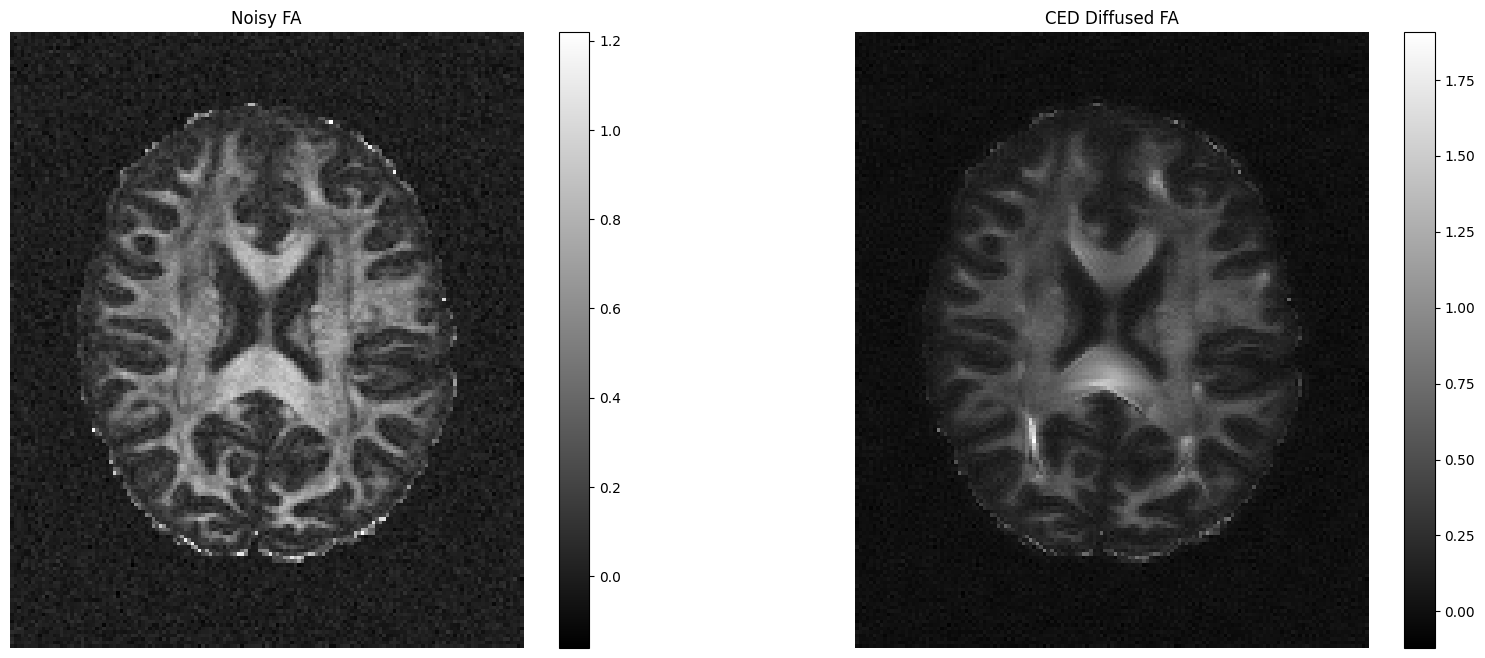

In [13]:
plotting.plot_side_by_side(IMG_noisy, img, title_a="Noisy FA", title_b="CED Diffused FA")  # type: ignore

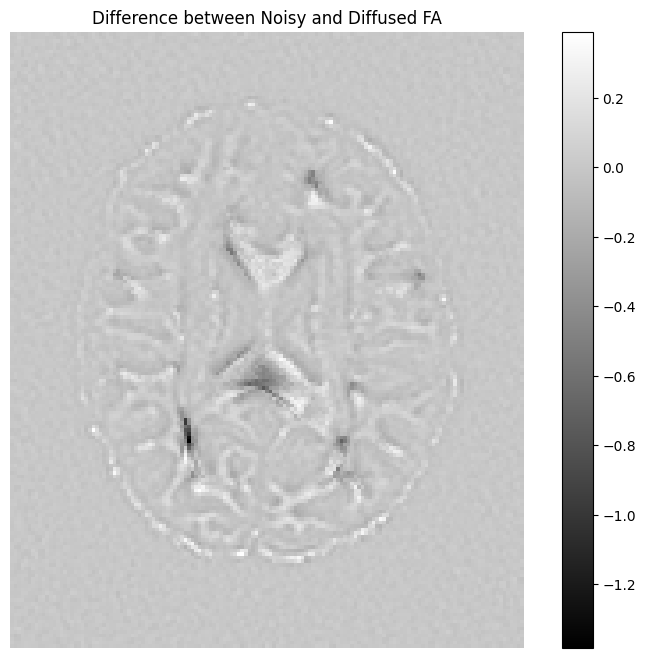

In [14]:
plotting.plot(IMG_noisy - img, title="Difference between Noisy and Diffused FA")  # type: ignore